In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth',200)

###Our data is a text file of English-German sentence pairs. First we will read the file using the function defined below.

In [2]:
#Function to read a raw text file

def read_text(filename):
  #open the file
  file = open(filename, mode='rt', encoding='utf-8')
  #read all text
  text = file.read()
  file.close()
  return text

###Now let's define a function to split the text into English-German pairs seperated by '\n' and then split these pairs into English sentences and German sentences.

In [3]:
#split a text into sentences

def to_lines(text):
  sents = text.strip().split('\n')
  sents = [i.split('\t') for i in sents]
  return sents

In [4]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

###The actual data contains over  150,000 sentence-pairs. However, we will use the first 50,000 sentence-[airs to reduce the training time of the model. 

In [5]:
deu_eng = deu_eng[:50000,:]

In [6]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Who else is in there?', 'Wer ist noch dort drin?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3395974 (CK) & #3407455 (Pfirsichbaeumchen)'],
       ['Who else was in here?', 'Wer war sonst noch hier drin?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3434402 (CK) & #3610264 (Jan_Schreiber)'],
       ['Who fixed the window?', 'Wer hat das Fenster hergerichtet?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #9855581 (DJ_Saidez) & #9855585 (brauchinet)']],
      dtype='<U537')

##Text to Sequence Conversion:

###To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentence into integer sequences if fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two seperate lists for English and German, resprctively.

In [7]:
#empty list

eng_1 = []
deu_1 = []

#populate the lists with sentence lenghts
for i in deu_eng[:,0]:
  eng_1.append(len(i.split()))

for i in deu_eng[:,1]:
  deu_1.append(len(i.split()))

In [8]:
length_df = pd.DataFrame({'eng':eng_1, 'deu':deu_1})


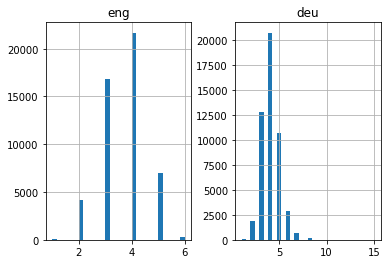

In [9]:
length_df.hist(bins=30)
plt.show()

###The maximum length of the German sentences is 11 and that of the English phrases is 8.

###Let's vectorize our data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [10]:
# function to build a tokenizer
def tokenization(items):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(items)
  return tokenizer

In [11]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6167


In [12]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10146


###Given below is a function to prepare the sequences. It will also perform sequence to a maximum sentence length as mentioned above.

In [13]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
  # integer encode sequences
  seq = tokenizer.texts_to_sequences(lines)
  # pad sequences with 0 values
  seq = pad_sequences(seq, maxlen=length, padding='post')
  return seq

#Model Building

###We will now split the data into train and test set for model training and evaluation, respectively.

In [14]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state=12)

###It's time to encode the sentences. We will encode German sentences as the input sequences and the English sentences as the target sequences. It will be done for both train and test datasets.

In [15]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [16]:
# prepare test data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

###Now, let's define our Seq2Seq model architechture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM kayer followed by a Dense layer as the decoder.

In [17]:
# build NMT model

def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  model = Sequential()
  model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
  model.add(LSTM(units))
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(units, return_sequences=True))
  model.add(Dense(out_vocab, activation='softmax'))
  return model

###We are using RMSprop oprtimizer in this model as it is usally a ggod choice for recurrent neural network.

In [18]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

###We have used 'sparse_categorical_crossentropy' as the loss function because it allows us to use thr target sequences as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our memory.

###We will train our model for 30 epochs and with a batch size of 512. We will also be using ModelCheckpoint() to save the best model with lowest validation loss.

In [19]:
filename = 'model.h1.04_ankit'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=10, 
                    batch_size=512,
                    validation_split=0.2,
                    callbacks=[checkpoint],
                    verbose=1)

Epoch 1/10
63/63 [==============================] - 206s 3s/step - loss: 4.2882 - val_loss: 2.7823

Epoch 00001: val_loss improved from inf to 2.78231, saving model to model.h1.04_ankit


INFO:tensorflow:Assets written to: model.h1.04_ankit/assets


INFO:tensorflow:Assets written to: model.h1.04_ankit/assets


Epoch 2/10
63/63 [==============================] - 188s 3s/step - loss: 2.7204 - val_loss: 2.7093

Epoch 00002: val_loss improved from 2.78231 to 2.70926, saving model to model.h1.04_ankit


INFO:tensorflow:Assets written to: model.h1.04_ankit/assets


INFO:tensorflow:Assets written to: model.h1.04_ankit/assets


Epoch 3/10
63/63 [==============================] - 188s 3s/step - loss: 2.5544 - val_loss: 2.5002

Epoch 00003: val_loss improved from 2.70926 to 2.50017, saving model to model.h1.04_ankit


INFO:tensorflow:Assets written to: model.h1.04_ankit/assets


INFO:tensorflow:Assets written to: model.h1.04_ankit/assets


Epoch 4/10
63/63 [==============================] - 188s 3s/step - loss: 2.3711 - val_loss: 2.3538

Epoch 00004: val_loss improved from 2.50017 to 2.35382, saving model to model.h1.04_ankit


INFO:tensorflow:Assets written to: model.h1.04_ankit/assets


INFO:tensorflow:Assets written to: model.h1.04_ankit/assets


Epoch 5/10
63/63 [==============================] - 189s 3s/step - loss: 2.2115 - val_loss: 2.2630

Epoch 00005: val_loss improved from 2.35382 to 2.26305, saving model to model.h1.04_ankit


INFO:tensorflow:Assets written to: model.h1.04_ankit/assets


INFO:tensorflow:Assets written to: model.h1.04_ankit/assets


Epoch 6/10
63/63 [==============================] - 190s 3s/step - loss: 2.0753 - val_loss: 2.1317

Epoch 00006: val_loss improved from 2.26305 to 2.13170, saving model to model.h1.04_ankit


INFO:tensorflow:Assets written to: model.h1.04_ankit/assets


INFO:tensorflow:Assets written to: model.h1.04_ankit/assets


Epoch 7/10
63/63 [==============================] - 191s 3s/step - loss: 1.9368 - val_loss: 2.0331

Epoch 00007: val_loss improved from 2.13170 to 2.03308, saving model to model.h1.04_ankit


INFO:tensorflow:Assets written to: model.h1.04_ankit/assets


INFO:tensorflow:Assets written to: model.h1.04_ankit/assets


Epoch 8/10
63/63 [==============================] - 189s 3s/step - loss: 1.8226 - val_loss: 1.9546

Epoch 00008: val_loss improved from 2.03308 to 1.95456, saving model to model.h1.04_ankit


INFO:tensorflow:Assets written to: model.h1.04_ankit/assets


INFO:tensorflow:Assets written to: model.h1.04_ankit/assets


Epoch 9/10
63/63 [==============================] - 190s 3s/step - loss: 1.7065 - val_loss: 1.8918

Epoch 00009: val_loss improved from 1.95456 to 1.89183, saving model to model.h1.04_ankit


INFO:tensorflow:Assets written to: model.h1.04_ankit/assets


INFO:tensorflow:Assets written to: model.h1.04_ankit/assets


Epoch 10/10
63/63 [==============================] - 189s 3s/step - loss: 1.6076 - val_loss: 1.8163

Epoch 00010: val_loss improved from 1.89183 to 1.81634, saving model to model.h1.04_ankit


INFO:tensorflow:Assets written to: model.h1.04_ankit/assets


INFO:tensorflow:Assets written to: model.h1.04_ankit/assets


###Let's compare the training loss and the validation loss

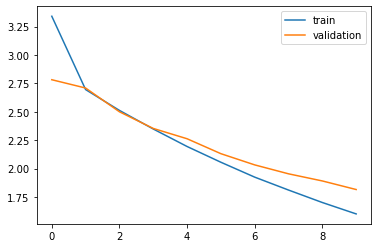

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'])
plt.show()

###Let's load the saved model to make predictions

In [21]:
model = load_model('model.h1.04_ankit')
preds = model.predict_classes(testX.reshape((testX.shape[0], testX.shape[1])))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [22]:
def get_word(n, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == n:
      return word
  return None

In [23]:
# convert predictions into text (English)
preds_text = []
for i in preds:
  temp = []
  for j in range(len(i)):
    t = get_word(i[j], eng_tokenizer)
    #print(t)
    if j > 0:
      if (t == get_word(i[j-1], eng_tokenizer)) or (t==None):
        temp.append("")
      else:
        temp.append(t)

    else:
      if(t==None):
        temp.append('')
      else:
        temp.append(t)
        
  preds_text.append(" ".join(temp))

In [24]:
pred_df = pd.DataFrame({'actual': test[:,0], 'predicted':preds_text})

In [25]:
pd.set_option('display.max_colwidth',200)

In [26]:
pred_df.head(15)

,actual,predicted
0,Who wrote the book?,who wrote this car
1,We failed.,we going
2,We're waiting.,we're going
3,They're yours.,you're are
4,He is in his library.,he is a man
5,Tom made an apology.,tom needs me
6,I'm allergic to corn.,i'm am to
7,Why are you so busy?,why are you so
8,I need a spatula.,i need a money
9,Add more water to it.,give your


In [27]:
pred_df.tail(15)

,actual,predicted
9985,I went home early.,i have
9986,Tom's repulsive.,tom is a
9987,Woods burn easily.,flat measured reach
9988,She didn't show up.,she didn't him
9989,Do you like music?,do you like
9990,Pink is for girls.,is tom's
9991,Has anybody come?,it you
9992,We had fun.,we have
9993,I am writing an SMS.,i have a
9994,I was too small.,i was a
